In [87]:
import matplotlib.pyplot as pl
import numpy as np
import torch
import autograd
import autograd.numpy as anp
import gwot
from gwot import sim
import gwot.bridgesampling as bs
import ot.plot
import sklearn
from sklearn import metrics

In [88]:
import sys
sys.path.append('../../code/')
#from sinkhorn_iterates import sinkhorn
from utils import kernel,def_colormap 
from semi_sinkhorn_iterates import semi_sinkhorn
from semi_linear_solver import semi_UOT_KL,semi_UOT_MMD

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(device)
torch.set_default_dtype(torch.float64)

cpu


In [90]:
# setup potential function
dim=4
def Psi(x, t, dim = dim):
    x0 = 1.4*anp.array([1, 1] + [0, ]*(dim - 2))
    x1 = -1.25*anp.array([1, 1] + [0, ]*(dim - 2))
    return 1.25*anp.sum((x - x0)*(x - x0), axis = -1) * anp.sum((x - x1)*(x - x1), axis = -1) + 10*anp.sum(x[:, 2:]*x[:, 2:], axis = -1)
# get gradient 
dPsi = autograd.elementwise_grad(Psi)

In [91]:
# setup simulation parameters
sim_steps = 1000 # number of steps to use for Euler-Maruyama method
T = 10 # number of timepoints
N = 8 # number of particles per timepoint
D = 1 # diffusivity
t_final = 1 # simulation run on [0, t_final]

In [92]:
# branching rates
R = 10
beta = lambda x, t: R*((anp.tanh(2*x[0]) + 1)/2)
delta = lambda x, t: 0
r = lambda x, t: beta(x, t) - delta(x, t)

In [93]:
# function for particle initialisation
ic_func = lambda N, d: anp.random.randn(N, d)*0.1

# setup simulation object
sim = gwot.sim.Simulation(V = Psi, dV = dPsi, birth_death = True, 
                          birth = beta, 
                          death = delta,
                          N = anp.repeat(N, T), 
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None)

In [94]:
np.random.seed(3)
n = 1 #nb of sampling
paths = sim.sample_trajectory(steps_scale = int(sim_steps/sim.T), N = n*N)
paths.shape

(8, 10, 4)

In [95]:
X_max= np.transpose(paths,(1,0,2))
X_max=X_max.reshape(-1,dim)
X_max=np.column_stack((np.kron(np.linspace(0, 1*t_final, T), np.ones(N*n)),1*X_max))
X_max=X_max.reshape(T,N*n,dim+1)

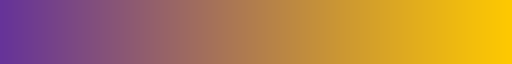

In [96]:
cmp=def_colormap()
cmp

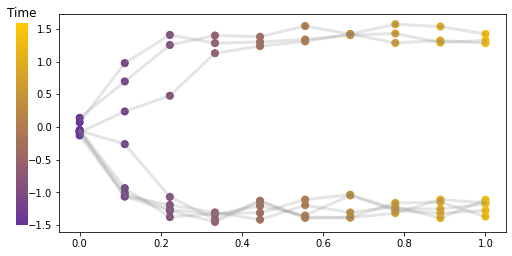

In [97]:
s=5e1
d=0
fig=pl.figure(figsize=(8,4))
ax=pl.subplot(1,1,1)
cmap = pl.get_cmap('BuGn')
for i in range(T-1):
    ot.plot.plot2D_samples_mat(X_max[i,:,[0,d+1]].T, X_max[i+1,:,[0,d+1]].T, np.eye(n*N), c="grey",alpha=.2,linewidth=3)
im=pl.scatter(X_max[:,:,0],X_max[:,:,d+1],c=np.kron(np.arange(T),np.ones(N*n)),s=s,cmap=cmp,vmin=0,vmax=10*t_final)
#pl.xlabel("Time",size=30)
#pl.ylabel("$x_0$",size=30)
#ax.set_yticks([])
#ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_xticklabels([])

cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("Time")
pl.axis("off")

pl.savefig("../../Figures/UOT/trajectory_inf.pdf",bbox_inches='tight')

In [98]:
def sigmoide(x,lam=10):
    return 1/(1+np.exp(-lam*x))

In [99]:
x=np.linspace(0,1,10)

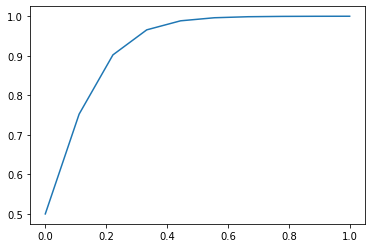

In [100]:
pl.plot(x,sigmoide(x))

In [85]:
X_shift=np.random.normal(np.max(X_max[:,:,1],1)+10*sigmoide(x),scale=.1,size=(10,))
X_shift

array([ 5.04302516,  8.32433547, 10.28797751, 11.15822769, 11.35893784,
       11.53565965, 11.56035025, 11.60824052, 11.50053869, 11.40169537])

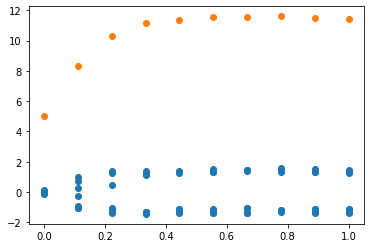

In [86]:
pl.scatter(X_max[:,:,0],X_max[:,:,d+1])
pl.scatter(x,X_shift)

In [75]:
X_max[:,:,1].shape

(10, 8)

In [48]:
np.max(X_max[:,:,1],1)

array([0.13894565, 0.97658976, 1.40834452, 1.39916285, 1.38063238,
       1.54427916, 1.4216382 , 1.57143478, 1.53641669, 1.42275622])

# Random subsampling

In [37]:
np.random.seed(1)
paths_red=np.zeros((N,T,dim))
for i in range(T):
    idx=np.concatenate((np.ones(N),np.zeros(n*N-N)))
    np.random.shuffle(idx)
    paths_red[:,i,:]=paths[idx.astype(bool),i,:]

In [38]:
X= np.transpose(paths_red,(1,0,2))
X=X.reshape(-1,dim)
X=np.column_stack((np.kron(np.linspace(0, 1*t_final, T), np.ones(N)),X))
X=X.reshape(T,N,dim+1)
print(X.shape)

(20, 10, 5)


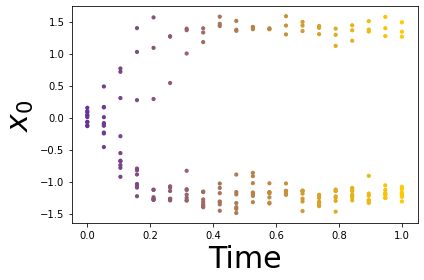

In [41]:
d=0
pl.figure(figsize=(6,4))
pl.scatter(X[:,:,0],X[:,:,d+1],c=np.kron(np.arange(T),np.ones(N)),s=10,cmap=cmp)#,vmin=0,vmax=1*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
pl.tight_layout()
#pl.savefig("result/trajectory/sub_sampling.pdf",bbox_inches='tight')

### UOT KL

In [42]:
# UOT KL Sinkhorn 
Y2=np.array(X, copy=True)
Y2e=np.array(X, copy=True)
w2=np.ones((X.shape[0],X.shape[1]))
lam2=45
for i in range(T-1):    
    #Linear solver
    C=torch.tensor(ot.dist(Y2[i,:,1:],Y2[i+1,:,1:]))
    P=semi_UOT_KL(w2[i],w2[i+1],C,lam2=lam2,solver="CLARABEL")
    Y2[i+1,:,:]=P@Y2[i+1,:,:]
    print(np.round(P.sum()),end=" ")
    
    #Sinkhorn iterates
    C=torch.tensor(ot.dist(Y2e[i,:,1:],Y2e[i+1,:,1:]))
    u,v,G=semi_sinkhorn(torch.tensor(w2[i]),torch.tensor(w2[i+1]),C,lam2=lam2,eps=4e-3,numiter=500,pen="kl")
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    P=P.numpy()
    Y2e[i+1,:,:]=P@Y2e[i+1,:,:]
    
    print(np.round(P.sum()),end=" ")

10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 

In [43]:
C = sklearn.metrics.pairwise_distances(np.transpose(Y2[:,:,1:],(1,0,2)).reshape(-1,T*dim),
                                       np.transpose(X_max[:,:,1:],(1,0,2)).reshape(-1,T*dim), metric = 'sqeuclidean')
Ce = sklearn.metrics.pairwise_distances(np.transpose(Y2e[:,:,1:],(1,0,2)).reshape(-1,T*dim),
                                        np.transpose(X_max[:,:,1:],(1,0,2)).reshape(-1,T*dim), metric = 'sqeuclidean')
W=ot.emd2([],[],C)
We=ot.emd2([],[],Ce)
print(W)
print(We)

1.1660654986403556
1.0789222168592625


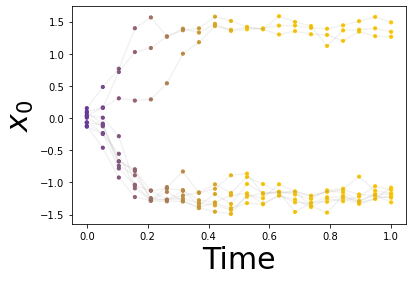

In [44]:
d=0
pl.figure(figsize=(6,4))
pl.scatter(Y2[:,:,0],Y2[:,:,d+1],c=np.kron(np.arange(T),np.ones(N)),s=10,cmap=cmp,vmin=0,vmax=10*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y2[i,:,[0,d+1]].T, Y2[i+1,:,[0,d+1]].T, np.eye(N), c="grey",alpha=.1)
#pl.savefig("result/trajectory/UOT_KL.pdf",bbox_inches='tight')

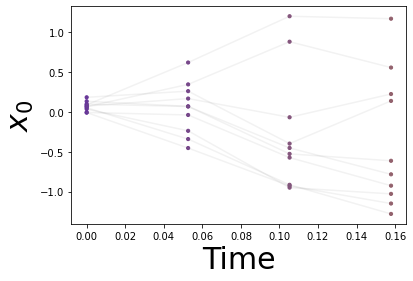

In [32]:
d=0
pl.figure(figsize=(6,4))
pl.scatter(Y2e[:,:,0],Y2e[:,:,d+1],c=np.kron(np.arange(T),np.ones(N)),s=10,cmap=cmp,vmin=0,vmax=10*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y2e[i,:,[0,d+1]].T, Y2e[i+1,:,[0,d+1]].T, np.eye(N), c="grey",alpha=.1)
#pl.savefig("result/trajectory/UOT_KLe.pdf",bbox_inches='tight')